# **과제2 : 챗봇 만들기2**

## 0.미션

* 예비 에이블러들을 위한 QA 챗봇 모델 만들기2
    * Vector DB에 데이터 추가하기
    * Retriever, memory, LLM를 연결하기
    * 실행시 이력 DB 생성하고 기록하기
    * test

## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
from datetime import datetime

import openai

from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### (2) OpenAI API Key 확인
* 환경변수로 등록된 Key 확인하기

In [2]:
# 환경변수에서 키 불러오기
api_key = os.getenv('OPENAI_API_KEY')
print(api_key[:5]) 

sk-pr


* 만약 환경변수 키 설정이 잘 안된다면 아래 코드셀의 주석을 해제하고, 자신의 api key를 입력하고 실행
    * 아래 코드는 키 지정을 **임시**로 수행함.
    * 파이썬 파일(.ipynb, .py)안에서 매번 수행해야 함.

In [3]:
# os.environ['OPENAI_API_KEY'] = '여러분의 OpenAI API키' 
# openai.api_key = os.getenv('OPENAI_API_KEY')

## **2.Vector DB 만들기**

* 데이터 로딩 
    * 1일차에서 제공한 csv 파일의 구조를 그대로 이용
    * 에이블스쿨 홈페이지 FAQ 데이터 수집(https://aivle.kt.co.kr/home/brd/faq/main?mcd=MC00000056)
        * 모든 질문을 csv 형태로 저장
    * 데이터프레임으로 저장하기

In [4]:
data = pd.read_csv('aivleschool_qa.csv', encoding='utf-8')
data.head()

,구분,QA
0,모집/선발,최종 학력 또는 전공과 관계없이 지원할 수 있나요?\nKT 에이블스쿨은 정규 4년제...
1,모집/선발,35세 이상은 지원할 수 없나요?\n본 교육 과정은 34세 이하를 대상으로 하는 교...
2,모집/선발,미취업자의 기준이 뭔가요?\n미취업자의 기준은 아래와 같습니다.\n1) 기간의 정함...
3,모집/선발,"직장인도 지원할 수 있나요?\nKT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시..."
4,모집/선발,아르바이트를 하고 있는데 지원할 수 있나요?\n고용보험에 가입이 되어 있는 경우 1...


* 벡터 데이터베이스
    * 1일차 벡터 데이터베이스를 그대로 이용
        * Embedding 모델 : text-embedding-ada-002
        * DB 경로 : ./db



In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

database = Chroma(persist_directory="./db",
                    embedding_function = embeddings
)

* 데이터 입력
    * 기존 입력을 모두 제거하고 추가 사항만 모두 입력
    * meta data로 '구분' 칼럼 값 추가하기

In [6]:
# 데이터프레임의 텍스트 열(시리즈)을 리스트로 변환
text_list = data['QA'].tolist()
# 구분도 추가
meta = data['구분'].tolist()

# 리스트 내용을 각각 document로 변환
documents = [Document(page_content=text_list[i], metadata={'category':meta[i]}) for i in range(data.shape[0])]

# Insert
database.add_documents(documents)

['f8648481-1807-43e7-be03-c6fb24850216',
 '6cefba9b-cd63-413d-8cd9-969777f1d0dd',
 'b149e931-2a6b-4a95-9ff8-1e8c432131e1',
 'ca8c02a3-4090-4503-bb7a-e294611bb8cf',
 'b07c01e2-25fc-40da-bb03-4671547aa0d2',
 '2e8ec702-653b-4b62-b85f-c4a74f3820bd',
 'b338a793-5612-4841-9a58-616e90196a74',
 '8bc84728-3339-4092-aa18-51ff85c683a2',
 '45464eee-d187-46c0-a742-e8266aac9cab',
 'cc229a1f-b335-49ab-90a9-a87a30683ab4',
 'bc7f6782-c95b-417b-9284-353651ee1e9e',
 'a20375e4-b8de-435d-8b7a-c4674ef308d7',
 'fca92fa0-6498-48e2-bc5d-8b3bb886e89e',
 '32456585-c5d0-4a86-b14b-1be30ba58d36',
 '712513f4-a93c-447c-83d4-0f5cd6e2cade',
 'a2539ecc-344b-4d86-aea0-9f1b9e754924',
 '7894ffc2-21ed-42a7-9368-08bd62369cb2',
 '836a03ea-9aaa-488c-8ed7-ff8ca3987c23',
 'df4b641a-1d14-4523-9db8-3ca54fcedc81',
 '9d1dc70b-27de-461e-89ed-6a4286213164',
 '7a8cfaef-18f4-40b3-8e44-e75251ab190f',
 'cb48e9f8-3e70-4e86-aaf9-47bd68acdc27',
 'a2aa96ba-cf8f-448c-8e10-d589ed7bf24b',
 '99b16c67-c5d9-42aa-b5d5-c8a4cc6c175b',
 '956681dd-c314-

* 입력된 데이터 조회

In [7]:
database.get()

{'ids': ['00bf1106-7dd9-4905-b304-13f3ba204116',
  '00e92c70-023a-46a3-90f2-bd417da3cac1',
  '0142a6df-9199-4a72-afb7-d7a0ba3bd7a2',
  '03fad2e9-407a-49a5-a8e7-29c848002261',
  '0897a375-8911-4059-8006-e39fbd15f85e',
  '09865ee8-9837-4f8b-b74c-f22c0a86dc8c',
  '0a447d4b-dcba-4351-887a-d985c3b4ac4d',
  '0ae8111b-b59b-4cad-b3bc-e205612c9cff',
  '0b2e709b-b653-46f9-87c9-1d72d8fd43cb',
  '0bbe54bd-a8ad-4e4c-9bd0-d0d353e2136f',
  '0bd05fe5-201e-4910-bb9c-28583e0484b3',
  '0c42897c-cb97-4f45-8cc3-1237e43104e1',
  '0cb2e3b6-6c1f-4661-aacf-036a2a0679ce',
  '0def69ea-3a2b-47d0-93e0-097e9ae408bd',
  '0e3aede2-5729-43ff-a7b2-c8a26cada8e0',
  '113e8e13-f061-4cb6-9205-1b494296f888',
  '11fcd903-f07f-4130-9944-f49665ef42a0',
  '12441403-e1c7-45b2-a95d-d763016dab1f',
  '12d84c22-9908-4f5c-8a66-fe438cac3b1a',
  '137d95f9-1bde-4931-a96b-0a6b9603420a',
  '14e8820c-7306-4a68-a186-19f1c09b4fce',
  '197d11a3-eb4c-4bd4-8ca0-bbb555753aae',
  '1a01d641-013d-4f11-8d4c-5f89934fcd52',
  '1a6c8fea-4e3d-4dfd-8bbf-

In [8]:
from bs4 import BeautifulSoup
import requests

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

database = Chroma(persist_directory="./db_crawl",
                    embedding_function = embeddings
)

- AIVLE School FAQ 웹크롤링 (쿠키 설정 매번 해주고 크롤링 해줘야함)

In [9]:
# 쿠키는 한번씩 FAQ 접속해서 새로 받아와야함
# https://aivle.kt.co.kr/home/brd/faq/main?mcd=MC00000056
cookies = {
    "SESSION": "a77fbcaf-07ea-4e09-9235-a5dd7ae94daa",
    "TS01e6903a": "01a4caa0effe370ef553d0220a790076589f552f869bd751391eea34777bccb858c1388fb36677b45429c0530479d6a55ac9be1124b41b48956af86fb3d9f3f47cab054ab4"
}

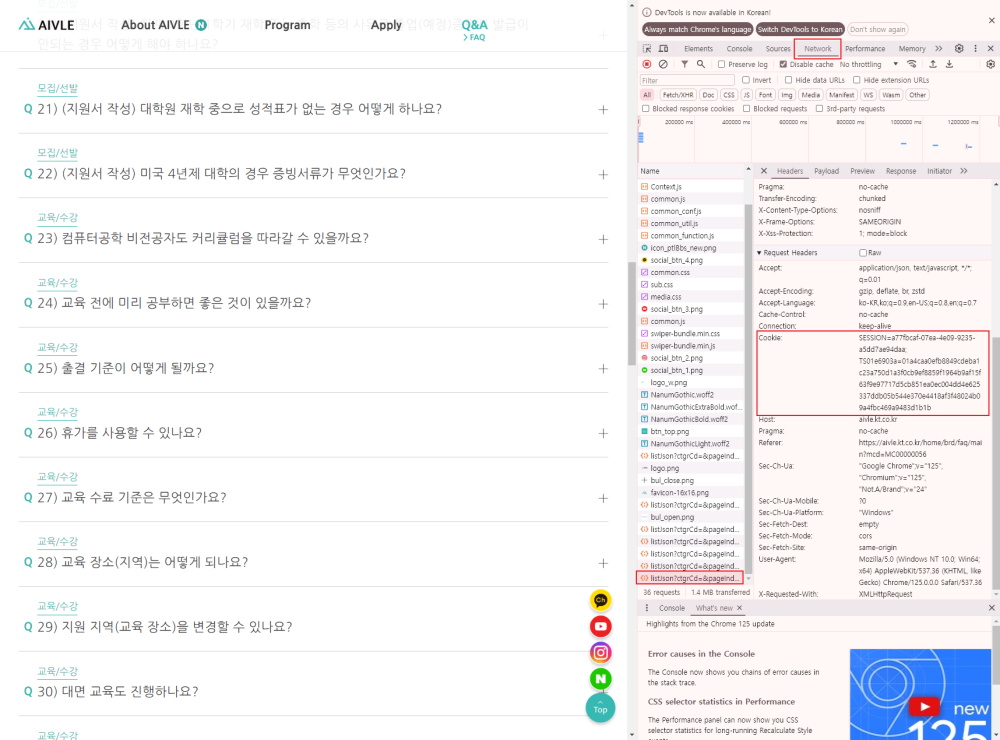

In [10]:
for i in range(1, 8):
    url=f"https://aivle.kt.co.kr/home/brd/faq/listJson?ctgrCd=&pageIndex=1"
    response=requests.get(url=url, cookies=cookies)
    data_json=response.json()
    for data in data_json['returnList']:
        category = data['ctgrNm']
        title = ' '.join(data['atclTitle'].split(' ')[1:-1])
        text = title + '\n\n' + data['atclCts']
        # 하나씩 db에 업데이트
        documents = [Document(page_content=text, metadata={'category':category})]
        database.add_documents(documents)

- 에이블러 기자단 내용 크롤링 (네이버 블로그)

In [11]:
# 한규현, 박보름, 이성연, 조미정 에이블러 정보 dict로 구성
ailver_name = {'kyudori46':'한규현','baenan1':'박보름','highhopes_467':'이성연','jeongs-':'조미정'}
# 각 기자단의 네이버 블로그 포스트 넘버
kyu_urls = [223353474363, 223353602475, 223363340648, 223369341688, 223379268158, 223379283550, 223384752104, 223392367141, 223399387919, 223410231594, 223413389107, 223430137996, 223430185140, 223437808599, 223447029386, 223452981951]
bae_urls = [223330592751, 223361235419, 223367080906, 223369131653, 223375736102, 223379189733, 223384500027, 223393093935, 223393167027, 223399619261, 223401773905, 223413449534, 223413470602, 223422620998, 223424523820, 223434180183, 223437179256, 223448184762, 223448639433, 223459592529, 223464757087]
hig_urls = [223393586675, 223393780264, 223431279286, 223431325035, 223460504578, 223460556424]
jeo_urls = [223362028007, 223376223294, 223387647149, 223400660070, 223415209732, 223421473182, 223438014072, 223452922426]
# 반복문으로 넣자
for aivler, urls in zip(ailver_name.keys(), (kyu_urls, bae_urls, hig_urls, jeo_urls)):
    # 기자단 글 내용 초기화
    text_list = []
    # 해당 에이블러의 기자단 글 긁어오기
    for n in urls:
        url=f'https://blog.naver.com/PostView.naver?blogId={aivler}&logNo={n}&redirect=Dlog&widgetTypeCall=true&noTrackingCode=true&directAccess=false'
        response = requests.get(url)
        dom = BeautifulSoup(response.text, 'html.parser')
        elements = dom.select('.se-module-text')
        text = [element.text.strip() for element in elements]
        text_list.append('\n'.join(text))
    # 해당 에이블러 이름으로 카테고리 넣어서 db에 추가
    documents = [Document(page_content=text, metadata={'category':f'{ailver_name[aivler]} 기자단'}) for text in text_list]
    database.add_documents(documents)

- 에이블러 기자단 내용 크롤링 (티스토리)

In [12]:
# 오용석, 이민희, 이미지, 이종은 에이블러 정보 dict로 구성
ailver_name = {'samuel-oh':'오용석','rose-brown':'이민희','studybook':'이미지','bellv':'이종은'}
# 각 기자단의 티스토리 블로그 포스트 넘버
sam_urls = [2, 3]
ros_urls = [42, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57]
stu_urls = [111, 116, 119, 122, 123]
bel_urls = [260, 261, 271, 283, 284]
# 반복문으로 넣자
for aivler, urls in zip(ailver_name.keys(), (sam_urls, ros_urls, stu_urls, bel_urls)):
    # 기자단 글 내용 초기화
    text_list = []
    # 해당 에이블러의 기자단 글 긁어오기
    for n in urls:
        url=f'https://{aivler}.tistory.com/{n}'
        response = requests.get(url)
        dom = BeautifulSoup(response.text, 'html.parser')
        # 제목 따로 긁어와주고
        title = dom.select_one('title')
        title = title.text
        # 본문 내용 따로 긁어와주자
        elements = dom.select('#article-view > div > p')
        text = [element.text.strip() for element in elements]
        # text_list 에 추가
        text_list.append(title+'\n\n'+'\n'.join(text))
    # 해당 에이블러 이름으로 카테고리 넣어서 db에 추가
    documents = [Document(page_content=text, metadata={'category':f'{ailver_name[aivler]} 기자단'}) for text in text_list]
    database.add_documents(documents)

- 에이블러 기자단 내용 크롤링 (velog - 윤영인 에이블러)

In [13]:
text_list = []
urls = ['AIVLE-3주차1-1차-미니-프로젝트', 'AIVLE-KT-에이블스쿨-AI트랙-5기-합격후기', 'AIVLE-5주차-2차-미니-프로젝트-앤나-회식을-곁들인', 'AIVLE-11주차-HAPPY-1차-에이블데이']
for t in urls:
    # 윤영인 에이블러 velog 주소
    url=f'https://velog.io/@o_o_o/{t}'
    response = requests.get(url)
    dom = BeautifulSoup(response.text, 'html.parser')
    # 제목 따로 긁어와주고
    title = dom.select_one('.head-wrapper > h1')
    title = title.text
    # 본문 내용 따로 긁어와주자 (뭔가 원하는 선택자로 해서 잘 안됨...왜 이렇게 해야 p 태그만 긁어와지는지 아직도 모르겠음)
    elements = dom.select('.sc-eGURor > h2,p')
    text = [element.text.strip() for element in elements]
    # text_list 에 추가
    text_list.append(title+'\n\n'+'\n'.join(text))
# 해당 에이블러 이름으로 카테고리 넣어서 db에 추가
documents = [Document(page_content=text, metadata={'category':'윤영인 기자단'}) for text in text_list]
database.add_documents(documents)

['818cc608-4bd2-45c3-9563-7946fed22fdc',
 '8b28d6f8-c7b3-4566-9901-7136224bc3ff',
 '657c9984-6065-4ce3-8606-e873a6177a46',
 '39c165a4-d67f-451f-8519-ac71c31bef38']

## **3.RAG+LLM모델**

* 모델 : ConversationalRetrievalChain
    * LLM 모델 : gpt-3.5-turbo
    * retriever : 벡터DB
        * 유사도 높은 문서 3개 가져오도록 설정
    * memory 사용
* 요구사항
    * 질문 history 관리를 위한 이력 저장 DB 생성
        * DB 명 : db_chatlog
        * 테이블 명 : history
            * id INTEGER PRIMARY KEY : 이렇게 설정하면 자동증가 값으로 채워짐
            * datetime TEXT : 질문시점 yyyy-mm-dd hh:mi:ss
            * query TEXT : 질문
            * sim1 REAL : 첫번째 문서의 유사도 점수
            * sim2 REAL : 두번째 문서의 유사도 점수
            * sim3 REAL : 세번째 문서의 유사도 점수
            * answer TEXT : 답변
        * 유사도 점수는 similarity_search_with_score 메서드를 이용해서 저장해야 함
        * 질문과 답변이 진행될 때마다 history 테이블에 데이터 입력

* 관리용 DB, 테이블 생성

In [14]:
path = './db_crawl/db_chatlog.db'
conn = sqlite3.connect(path)

# 커서 객체 생성
cursor = conn.cursor()

# 테이블 생성
cursor.execute('''
CREATE TABLE IF NOT EXISTS history (
    id INTEGER PRIMARY KEY,
    datetime TEXT NOT NULL,
    query TEXT NOT NULL,
    sim1 REAL NOT NULL,
    sim2 REAL NOT NULL,
    sim3 REAL NOT NULL,
    answer TEXT NOT NULL
)
''')

# 변경사항 커밋 (저장)
conn.commit()

# 연결 종료
conn.close()

* 모델 선언

In [15]:
retriever = database.as_retriever(search_kwargs={"k": 3})
chat = ChatOpenAI(model="gpt-3.5-turbo")

# 대화 메모리 생성 (이전 대화를 잊으려할 때 사용)
memory = ConversationBufferMemory(memory_key="chat_history", input_key="question", output_key="answer",
                                  return_messages=True)

# ConversationalRetrievalQA 체인 생성
qa = ConversationalRetrievalChain.from_llm(llm=chat, retriever=retriever, memory=memory,
                                           return_source_documents=True,  output_key="answer")

* 모델 사용 및 이력 확인

In [16]:
from datetime import datetime
# db_chatlog 에 연결
conn = sqlite3.connect(path)

while True:
    query = input('질문 > ').strip()
    if len(query) == 0:
        break
    print(f'질문 : {query}')
    print('-' * 20)
    
    # 현재 시간
    dt = datetime.now()
    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # 유사도 점수
    sims = database.similarity_search_with_score(query, k = 3)
    sim1 = sims[0][1]
    sim2 = sims[1][1]
    sim3 = sims[2][1]
    
    # RAG로 응답 전달받기
    result = qa(query)
    
    # history에 집어넣기
    log = pd.DataFrame({'datetime': [dt], 'query': [query], 'sim1': [sim1], 'sim2': [sim2], 'sim3': [sim3], 'answer': [result["answer"]]})
    log.to_sql('history', conn, if_exists='append', index=False)

    print(f'답변 : {result["answer"]}')
    print('=' * 50)

# 로그 확인
df = pd.read_sql('SELECT * FROM history', conn)
display(df)
# 연결 종료
conn.close()

질문 : 에이블스쿨 설명해줘.
--------------------
답변 : 에이블스쿨은 KT에서 제공하는 교육 프로그램으로, AIVLE-EDU 플랫폼을 통해 교육을 제공합니다. 프로그램 시작 전에는 에이블에듀에서 사전교육을 받을 수 있고, 수령한 노트북을 활용하여 교육을 진행합니다. 프로그램 동안 다양한 활동과 이벤트가 있으며, 학습 및 프로젝트를 통해 실력을 향상시킬 수 있습니다. 또한, 자기주도적으로 학습과 활동을 통해 높은 수준의 노력을 인정받는 교육 프로그램이라고 할 수 있습니다.
질문 : 나이는 몇살부터 지원 가능해?
--------------------
답변 : 34세 이하를 대상으로 하는 교육이지만, 모집 시점에 35세라도 해당 연도 1월 1일 이후 출생자는 지원이 가능합니다.
질문 : 혹시 예 를 함께 설명해줄 수 있어?
--------------------
답변 : 에이블스쿨이 무엇을 가르치는지에 대한 구체적인 정보는 제공되지 않았습니다. 위에 제공된 정보에서는 에이블러로서의 경험과 학습 내용, 강의에 대한 감상 등이 주로 다뤄졌습니다. 그러므로 에이블스쿨의 예에 대한 구체적인 정보는 이 문서에서 확인할 수 없습니다.
질문 : 무엇을 가르치에 대한 예시 말고, 35세일 때 지원 가능하다는게 무슨 말인지에 대한 예시!
--------------------


Retrying langchain_community.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: HTTP code 522 from API (<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>


<title>api.openai.com | 522: Connection timed out</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


</head>
<body>
<div id="cf-wrapper">
    <div id="cf-error-details" class="p-0">
        <he

답변 : 35세일 때 지원 가능하다는 것은, 예를 들어 2024년 지원 시점에서 35세인 사람이라면 1989년 1월 1일 이후에 태어난 사람은 지원이 가능하다는 의미입니다. 즉, 신청하는 해당 연도의 1월 1일을 기준으로 생년월일이 1989년 이후인 사람은 지원 자격이 있는 것입니다.
질문 : 혹시 KT Wiz 야구 뭐가 있었다던데 간단한 정보 좀 알려줘.
--------------------
답변 : KT Wiz 야구 관람에 대한 정보에는 야구 경기 관람을 위한 이벤트, 응원법, 경기장 입구부터 경기 관람 후까지의 경험 등이 포함되어 있습니다. 또한, 응원법, 경기 관람을 더 즐겁게 만들어주는 요소들과 경기 중에 보여지는 정보(선수들의 이름, 영상, 볼, 스트라이크, 아웃 등)이 포함되어 있습니다.
질문 : 야구 보고 온 후기 같은거 없어? 그 후기에 대해서 간략히 말해달란거야.
--------------------
답변 : 네, KT위즈 홈 개막 경기를 관람한 후기가 있습니다. 관련 내용을 확인하시려면 [에이블스쿨 5주차 후기] 딥러닝 | KT위즈 홈 개막 경기 응원을 참고하시면 됩니다.
질문 : 아니 너가 알려달라고.
--------------------
답변 : 죄송하지만, 제가 알려줄 만한 정보가 없습니다.


,id,datetime,query,sim1,sim2,sim3,answer
0,1,2024-06-04 15:10:00,에이블스쿨 설명해줘.,0.315835,0.316610,0.317017,"에이블스쿨은 KT에서 제공하는 교육 프로그램으로, AIVLE-EDU 플랫폼을 통해 ..."
1,2,2024-06-04 15:10:18,나이는 몇살부터 지원 가능해?,0.251350,0.251350,0.251350,"34세 이하를 대상으로 하는 교육이지만, 모집 시점에 35세라도 해당 연도 1월 1..."
2,3,2024-06-04 15:10:41,혹시 예 를 함께 설명해줄 수 있어?,0.375434,0.383152,0.383649,에이블스쿨이 무엇을 가르치는지에 대한 구체적인 정보는 제공되지 않았습니다. 위에 제...
3,4,2024-06-04 15:11:13,"무엇을 가르치에 대한 예시 말고, 35세일 때 지원 가능하다는게 무슨 말인지에 대한...",0.239610,0.239610,0.239610,"35세일 때 지원 가능하다는 것은, 예를 들어 2024년 지원 시점에서 35세인 사..."
4,5,2024-06-04 15:12:35,혹시 KT Wiz 야구 뭐가 있었다던데 간단한 정보 좀 알려줘.,0.233996,0.298378,0.351710,"KT Wiz 야구 관람에 대한 정보에는 야구 경기 관람을 위한 이벤트, 응원법, 경..."
5,6,2024-06-04 15:13:05,야구 보고 온 후기 같은거 없어? 그 후기에 대해서 간략히 말해달란거야.,0.339617,0.377718,0.378457,"네, KT위즈 홈 개막 경기를 관람한 후기가 있습니다. 관련 내용을 확인하시려면 [..."
6,7,2024-06-04 15:13:18,아니 너가 알려달라고.,0.398321,0.410623,0.426912,"죄송하지만, 제가 알려줄 만한 정보가 없습니다."
